---
### this file just is used to process vedio using class Line()

In [1]:
import numpy as np
import pickle
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque

def find_corners(img,nx=9,ny=6,show=True):
    '''
    this function just for find corners in img. return corners
    '''
    ##read imgae
    image = cv2.imread(img)
    original = image # save original image
    ##convert to gray
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corner
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
     # If found, draw corners
    if ret == True and show == True:
       # Draw and display the corners
        cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.set_title('Original Image', fontsize=18)
        ax1.imshow(cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB))#must be cv2.imread(img),if it is the original , the result is tha same as image
        ax2.set_title("After finding corners",fontsize=18)
        ax2.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    return ret,corners
##find all corners in image
nx = 9
ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

objpoints = [] #3D point in real world
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')
for image in images:
    ret,corners = find_corners(image)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [7]:
class Line():
    def __init__(self):
         # Was the line found in the previous frame?
        self.found = False
        
        # Remember x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # Store recent x intercepts for averaging across frames
        self.xbottom = deque(maxlen=10)
        self.xtop = deque(maxlen=10)
        
        # Remember previous x intercept to compare against current one
        self.lastx_bottom = None
        self.lastx_top = None
        
        # Remember radius of curvature
        self.radius = None
        
        # Store recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # Count the number of frames
        self.count = 0
    
    def blind_search(self,x,y,image):
        '''
        this function is used in first few frames or when  the line can not be find in previous frame
        It uses a slinding window approach to detect peaks in a histogram of the
        binary thresholded image. Pixels in close proimity to the detected peaks are considered to belong
        to the lane lines.
        input argument:
        x, y = np.nonzero(np.transpose(combined_binary)),return the index
        '''
        #find point in the line
        xvals = []
        yvals = []
        nwindows = 8
        windows_height = np.int(image.shape[0]//nwindows)
       # print(windows_height)
        # Set the width of the windows +/- margin in  x direction
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        if self.found == False:
            for i in range(nwindows):
                top = 720-i*windows_height
                bottom = 720-(i+1)*windows_height
                histogram = np.sum(image[bottom:top,:],axis=0)
                midpoint = np.int(histogram.shape[0]//2)
               # print(midpoint)
                if self == Left:
                    peak = np.argmax(histogram[:midpoint])
                if self == Right:
                    peak = np.argmax(histogram[midpoint+1:])+midpoint
                low = peak - margin
                high = peak + margin#should be noticed that may be over the indice
                x_idx = np.where(((low < x)&(x < high)&((y > bottom) & (y < top))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
        if np.sum(xvals) > 0:
            self.found = True
        else:
            xvals = self.X
            yvals = self.Y
                
        return xvals,yvals,self.found
    
    def follow_search(self,x,y,image):
        '''
        This function is applied when the lane lines have been detected in the previous frame.
        It uses a sliding window to search for lane pixels in close proximity (+/- 25 pixels in the x direction)
        around the previous detected polynomial.
        '''
        xvals = []
        yvals = []
        nwindows = 8
        margin = 100
        windows_height = np.int(image.shape[0]//nwindows)
        
        if self.found == True:
            for i in range(nwindows):
                top = 720-i*windows_height
                bottom = 720-(i+1)*windows_height
                yval = np.mean([bottom,top])
                #use the fit parameter of previous 10 frames to calculate
                #equal to the peak
                xval = np.mean(self.fit0)*yval**2 + np.mean(self.fit1)*yval + np.mean(self.fit2)
                idx = np.where((x > (xval-margin))& (x < (xval+margin)) & (y < top)&(y > bottom))
                x_window,y_window = x[idx],y[idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
        if np.sum(xvals) == 0: 
                self.found = False # If no lane pixels were detected then perform blind search
        return xvals,yvals,self.found
                
    def radius_of_curvature(self, xvals, yvals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        #fit = np.polyfit(xvals*xm_per_pix,yvals*ym_per_pix,2)
        fit_cr = np.polyfit(yvals*ym_per_pix,xvals*xm_per_pix,2)
        #calculate the radius,曲率
        curverad = ((1 + (2*fit_cr[0]*np.max(yvals) + fit_cr[1])**2)**1.5) \
                                     /np.absolute(2*fit_cr[0])
        return curverad
    
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)#return the sorted result index
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    
    def get_intercepts(self, polynomial):
        '''
        get the intercept of this polynomial,when x= 0
        '''
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top
                

In [8]:
def process_vid(image,show=True):
    global Right,Left
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145 #the thresh is important   
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    #but this is not show in 
    plt.imshow(combined_binary,cmap="gray")
    #print(combined_binary)
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) #return two arrays ,one for rows, another for cols
    #print(x,y)
    
    #start to process image using class line
    # put the true in the first. if put it second ,it will run again
    if Left.found == True:
        leftx,lefty,Left.found = Left.follow_search(x,y,combined_binary)
    
    if Right.found == True:
        rightx,righty,Right.found = Right.follow_search(x,y,combined_binary)
        
    if Right.found == False:
        rightx,righty,Right.found = Right.blind_search(x,y,combined_binary)
        
    if Left.found == False:
        leftx,lefty, Left.found = Left.blind_search(x,y,combined_binary)
    
    #print(lefty) it's none
    #make sure the result has the same type
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
   # print(lefty) it's nan
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_bottom, leftx_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.xbottom.append(leftx_bottom)
    Left.xtop.append(leftx_top)
    leftx_bottom = np.mean(Left.xbottom)
    leftx_top = np.mean(Left.xtop)
    Left.lastx_bottom = leftx_bottom
    Left.lastx_top = leftx_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_bottom)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, leftx_top)
    lefty = np.append(lefty, 0)
    
    # Sort detected pixels based on the yvals
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_bottom, rightx_top = Right.get_intercepts(right_fit)
    
    # Average intercepts across 5 frames
    Right.xbottom.append(rightx_bottom)
    Right.xtop.append(rightx_top)
    rightx_bottom = np.mean(Right.xbottom)
    rightx_top = np.mean(Right.xtop)
    Right.lastx_bottom = rightx_bottom
    Right.lastx_top = rightx_top
    rightx = np.append(rightx, rightx_bottom)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, rightx_top)
    righty = np.append(righty, 0)
    
    # Sort right lane pixels
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels,the 10 frames mean value
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
    
    # Compute radius of curvature for each lane in meters
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
    
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_bottom+leftx_bottom)/2
    distance_from_center = abs((640 - position)*3.7/700) 
    
    ## change to real image
    Minv = cv2.getPerspectiveTransform(dst, src)
    # draw the result    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) ##birds eye
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([Right.fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))##change to real world
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
    Left.count += 1
    return result
    

In [ ]:
##test process_vid
Left = Line()
Right = Line()
process_vid()

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [01:37<00:01,  1.85s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



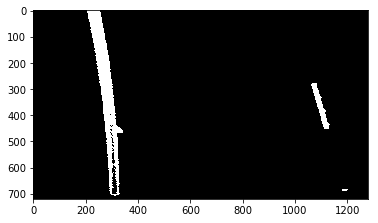

In [6]:

### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
Left = Line()
Right = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

In [9]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [13:43<00:00,  1.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 



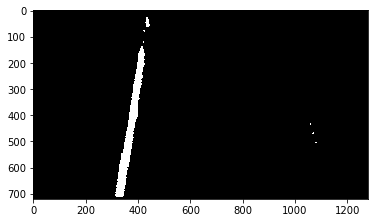

In [12]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
Left = Line()
Right = Line()
video_output = 'challenge_result.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

In [11]:
HTML("""
<video width = "640" height = "360" controls>
<source src = "{0}">
</video>
""".format("challenge_result.mp4"))